<a href="https://colab.research.google.com/github/Fall2024CS584/Lectures/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes

Remeber from last lecture that we can estimate

\begin{align*}
\log\left(\frac{P(Y=k| \mathbf{X}=\mathbf{x})}{P(Y=0| \mathbf{X}=\mathbf{x})}\right) &= \log\left(\frac{\pi_k \prod_{j=1}^d P(X_j=x_j|Y=k)}{\pi_0 \prod_{j=1}^d P(X_j=x_j| Y=0)}\right) \\
& = \log\left(\frac{\pi_k}{\pi_0}\right) + \sum_{j=1}^d \log\left(\frac{f_{j,k}(x_j)}{f_{j,0}(x_j)}\right)
\end{align*}

So we are interested in estimating
$$
f_{j,k}(x) = P(X_j = x| Y=k)
$$
and generally we can use any number of non-parametric kernel estimation techniques to accomplish this.

## Kernel Density Estimation

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (20, 10)

In [ ]:
def generate_classifier_data(rnge, k, d, sizes, seed):


    rng = numpy.random.default_rng(seed=seed)
    cs = rng.uniform(rnge[0], rnge[1], size=(k, d))
    mb = rng.normal(loc=0, scale=1, size=(k,d))
    noise = rng.normal(loc=0, scale=0.1, size=(d,d))
    sigma_signal = numpy.matmul(mb.T, mb)
    noisy_sigma = sigma_signal + noise
    sigma = numpy.matmul(noisy_sigma.T, noisy_sigma)
    classes = [rng.multivariate_normal(c, sigma, size=size) for c, size in zip(cs,sizes)]
    ys = [j*numpy.ones(shape=(size, 1)) for j, size in enumerate(sizes)]
    xs = numpy.vstack(classes)
    ys = numpy.vstack(ys)
    return (xs, ys)


In [ ]:
rnge=[-10,10]
k = 4
d = 2
sizes = [200, 30, 50, 100]
X,y = generate_classifier_data(rnge, k, d, sizes, 8675309)

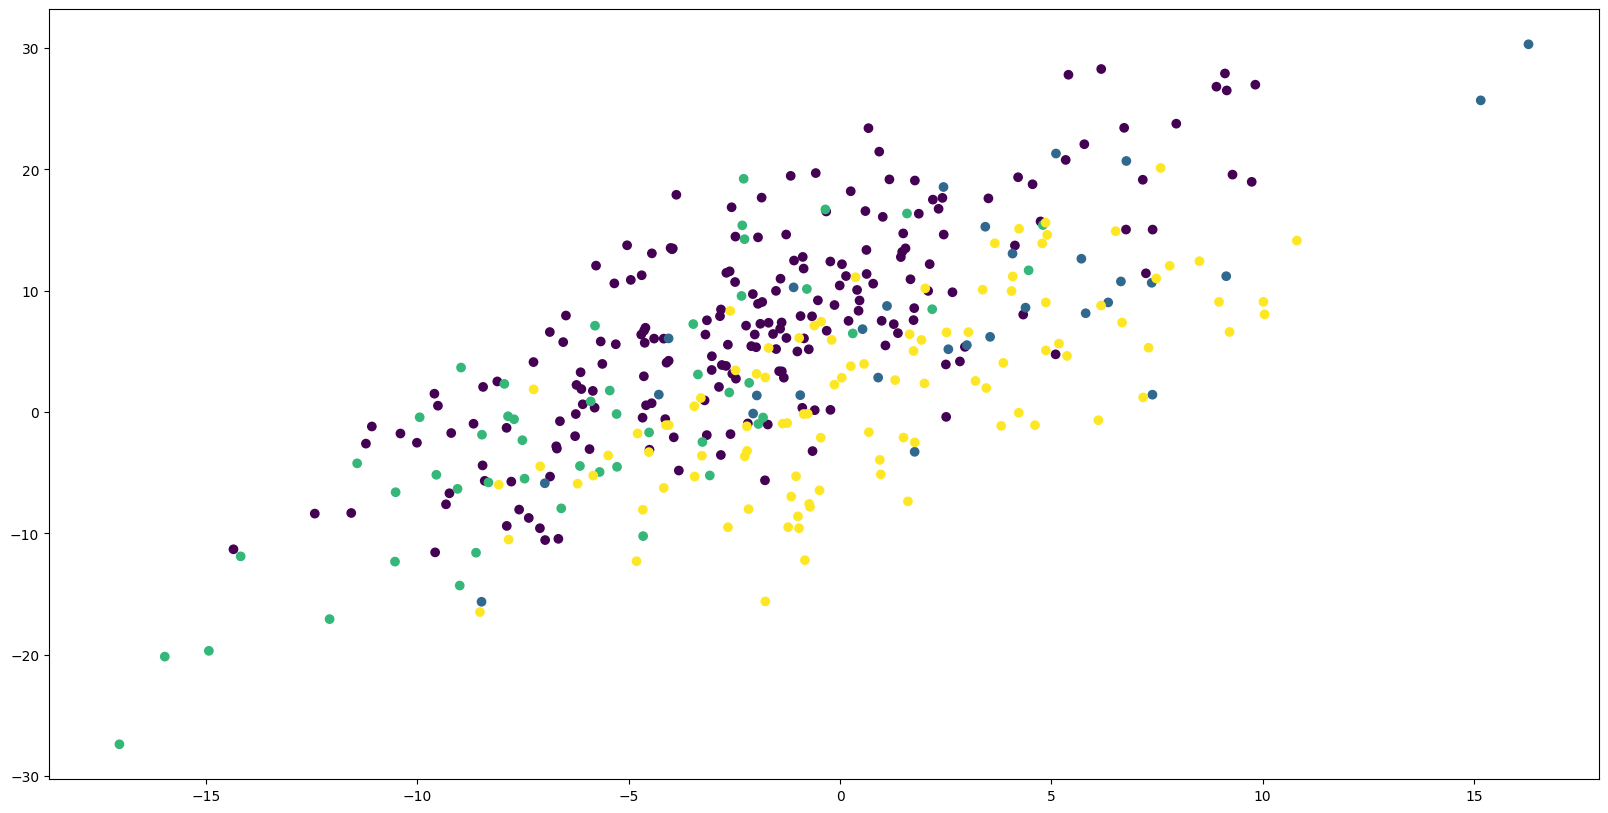

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [ ]:
class KDE():
  def __init__(self, kern):
    self.kern = kern

  def fit(self, X):
    self.X = X
    self.n = X.shape[0]
    self.h = 3.49*numpy.std(X)*numpy.float_power(self.n, -1.5)
    return KDEResult(self.X, self.n, self.h, self.kern)

class KDEResult():
  def __init__(self,X, n, h, kern):
    self.X = X
    self.n = n
    self.h = h
    self.kern = kern

  def predict(self, x):
    return numpy.sum([self.kern(x, b, self.h) for b in self.X])/self.n



In [ ]:
def simple_kern(x, b, h):
  if numpy.abs(x - b) < h:
    return 1/h
  else:
    return 0

def gaussian_kern(x,b, sigma):
  return 1/numpy.sqrt(2*numpy.pi*sigma**2)*numpy.exp(-(x - b)**2/(2*sigma))

def epanechnikov_kern(x, b, h):
  if numpy.abs(x - b) < h:
    t = (x - b)/h
    return 0.75*(1 - t**2)
  else:
    return 0

In [ ]:
kde = KDE(simple_kern)

In [ ]:
test_X = numpy.array([3.7,4.3, 5.5, 8.2])

In [ ]:
kderesult = kde.fit(test_X)

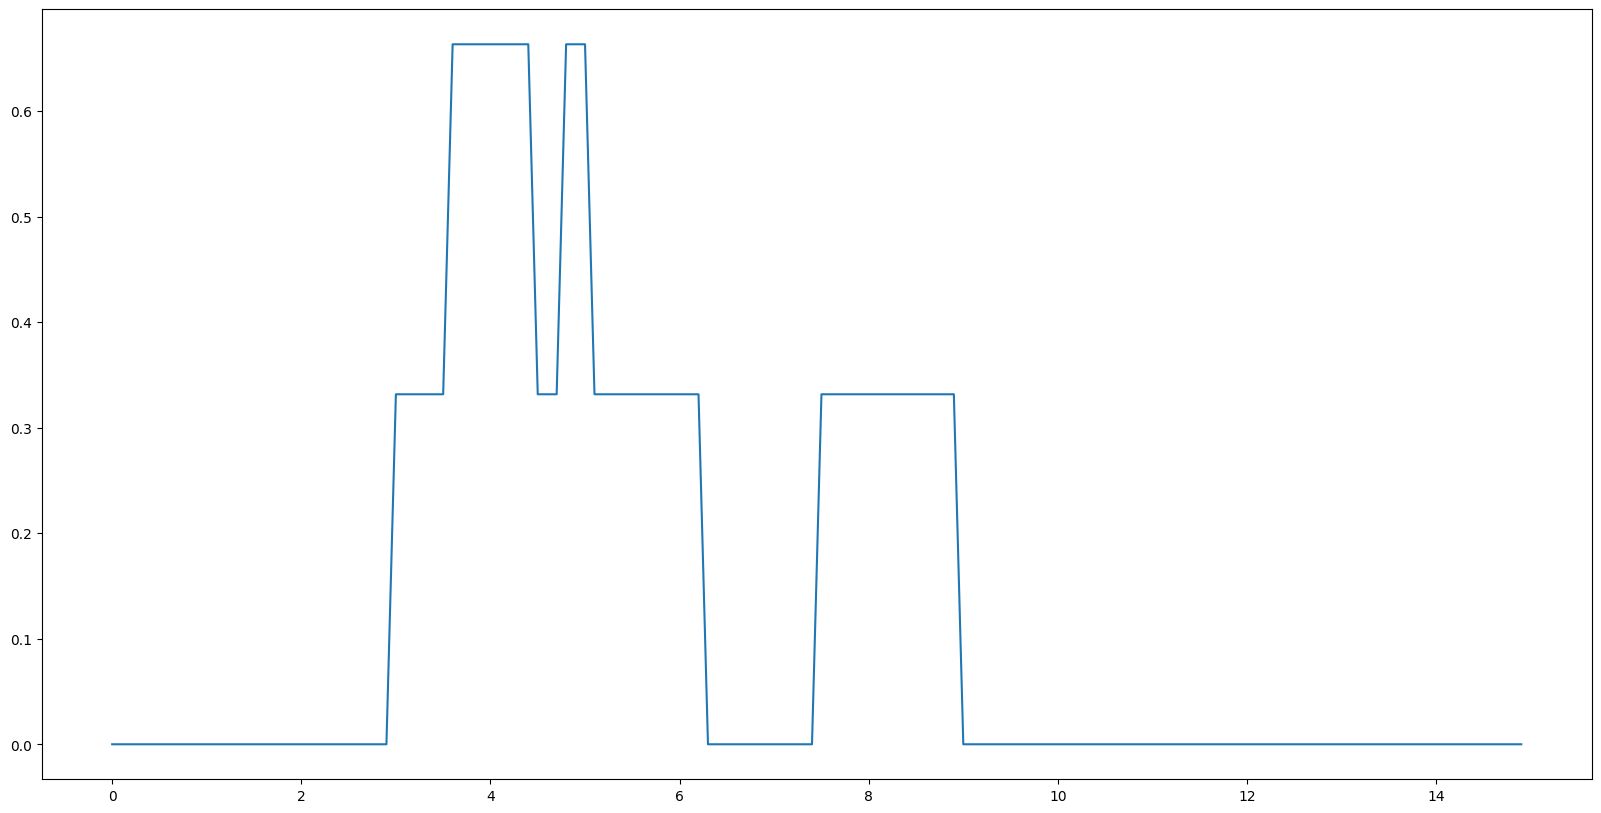

In [ ]:
xs = numpy.arange(0, 15, 0.1)
ys = [kderesult.predict(x) for x in xs]
plt.plot(xs, ys)
plt.show()

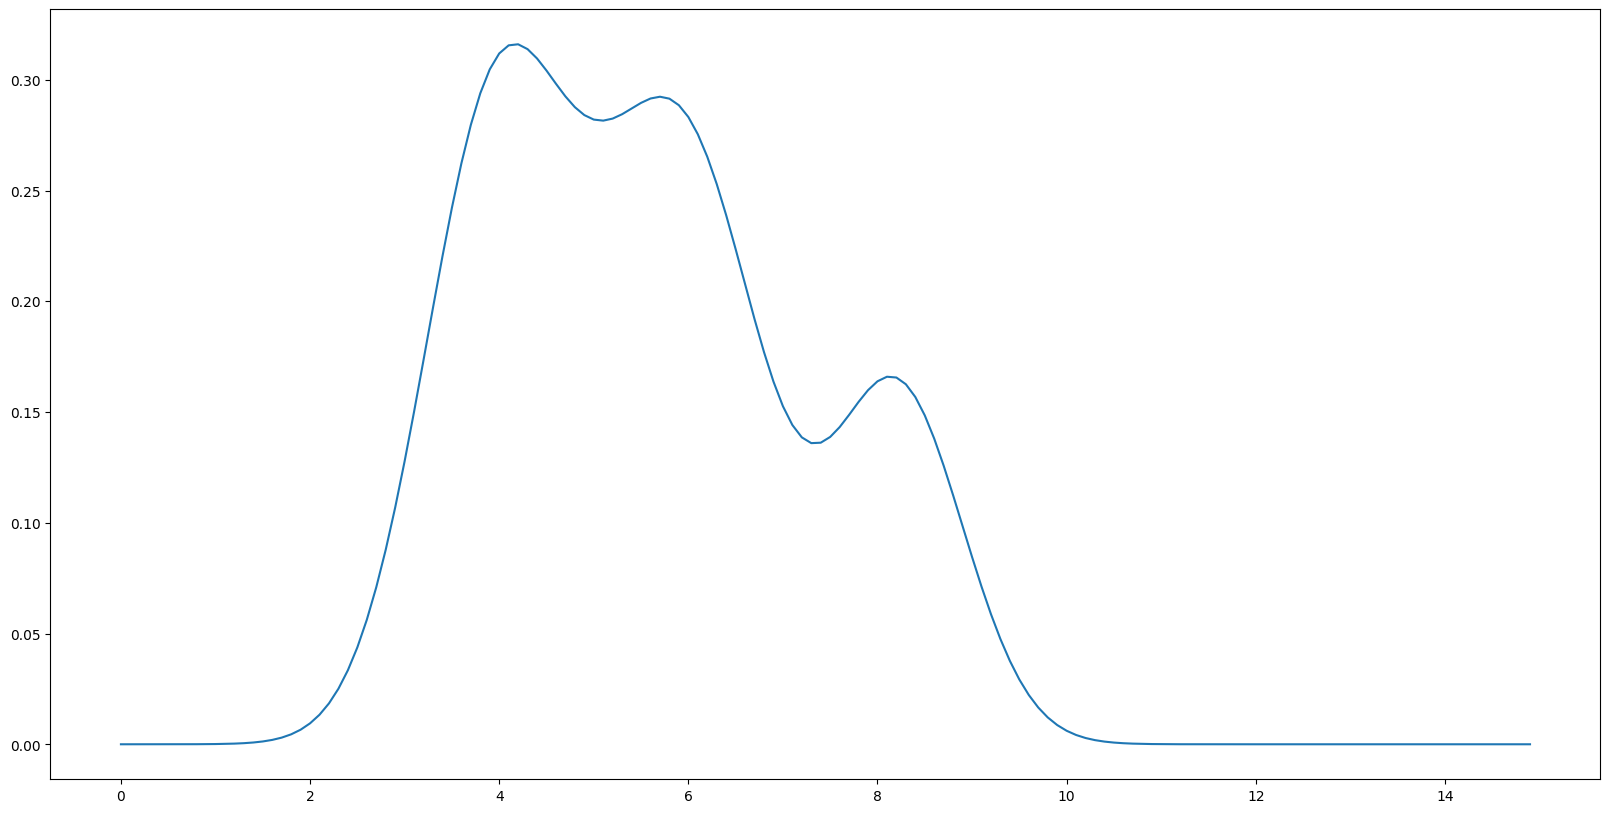

In [ ]:
kde = KDE(gaussian_kern)
test_X = numpy.array([3.7,4.3, 5.5, 6.3, 8.2])
result = kde.fit(test_X)
xs = numpy.arange(0, 15, 0.1)
ys = [result.predict(x) for x in xs]
plt.plot(xs, ys)
plt.show()

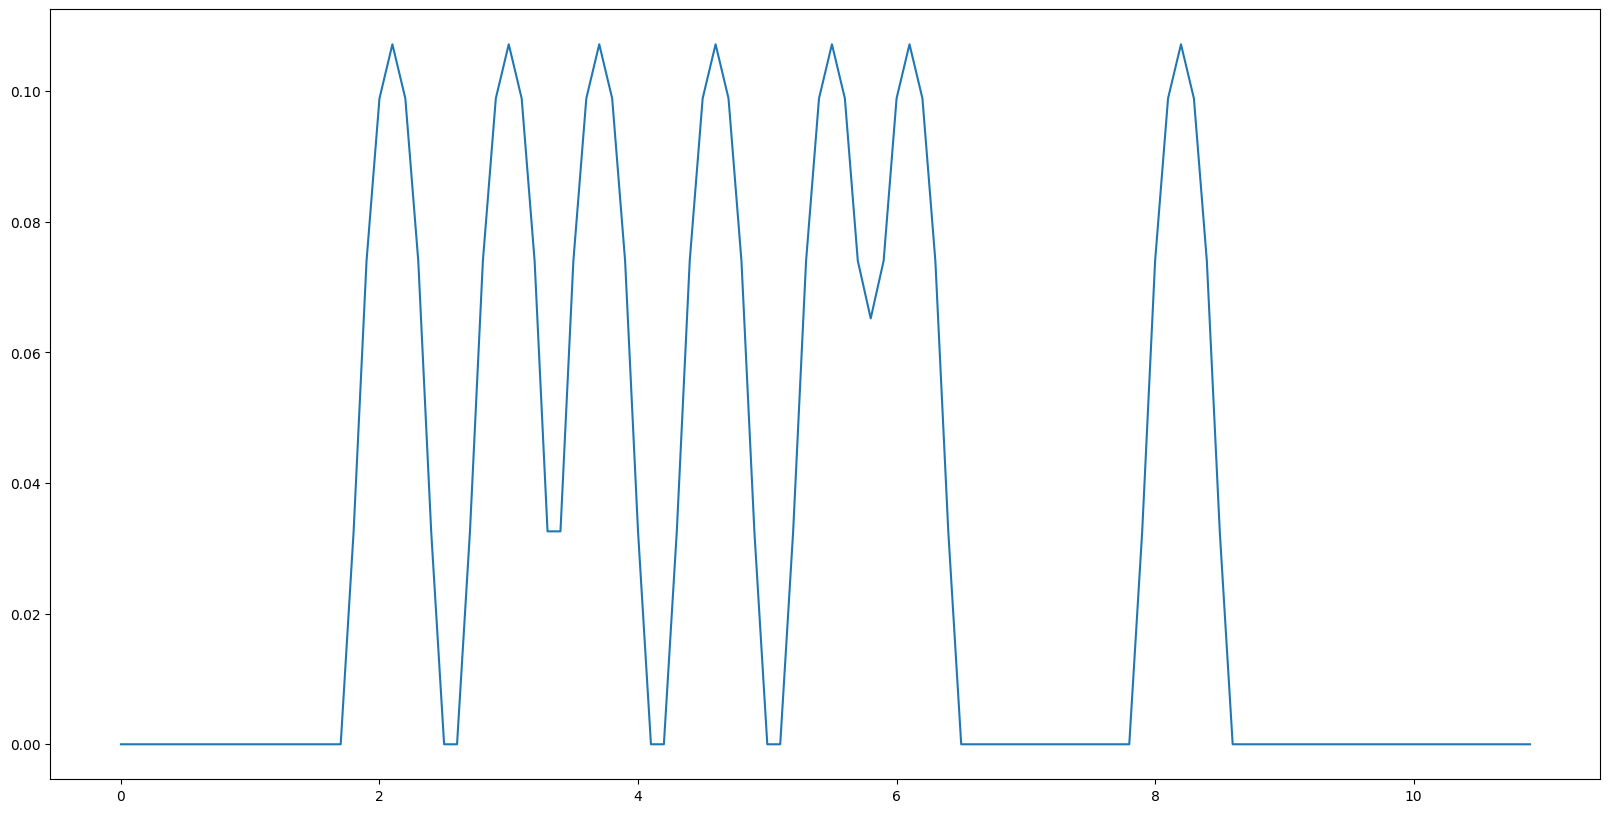

In [ ]:
kde = KDE(epanechnikov_kern)
test_X = numpy.array([2.1, 3.0, 3.7, 4.6, 5.5, 6.1, 8.2])
result = kde.fit(test_X)
xs = numpy.arange(0, 11, 0.1)
ys = [result.predict(x) for x in xs]
plt.plot(xs, ys)
plt.show()

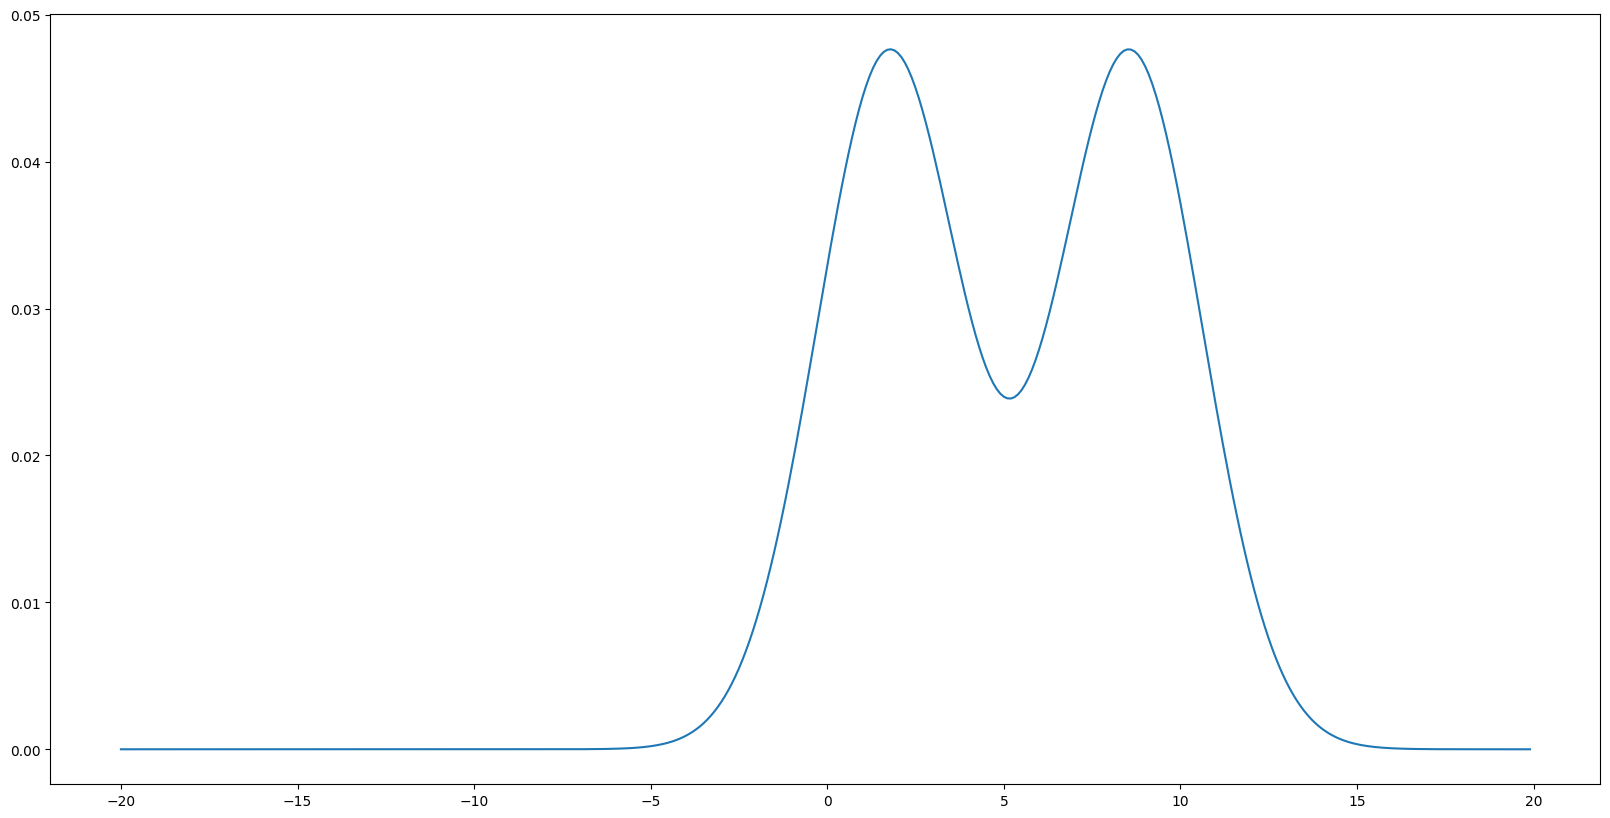

In [ ]:
kde = KDE(gaussian_kern)
result = kde.fit(X[0,:])
xs = numpy.arange(-20,20, 0.1)
ys = [result.predict(x) for x in xs]
plt.plot(xs, ys)
plt.show()

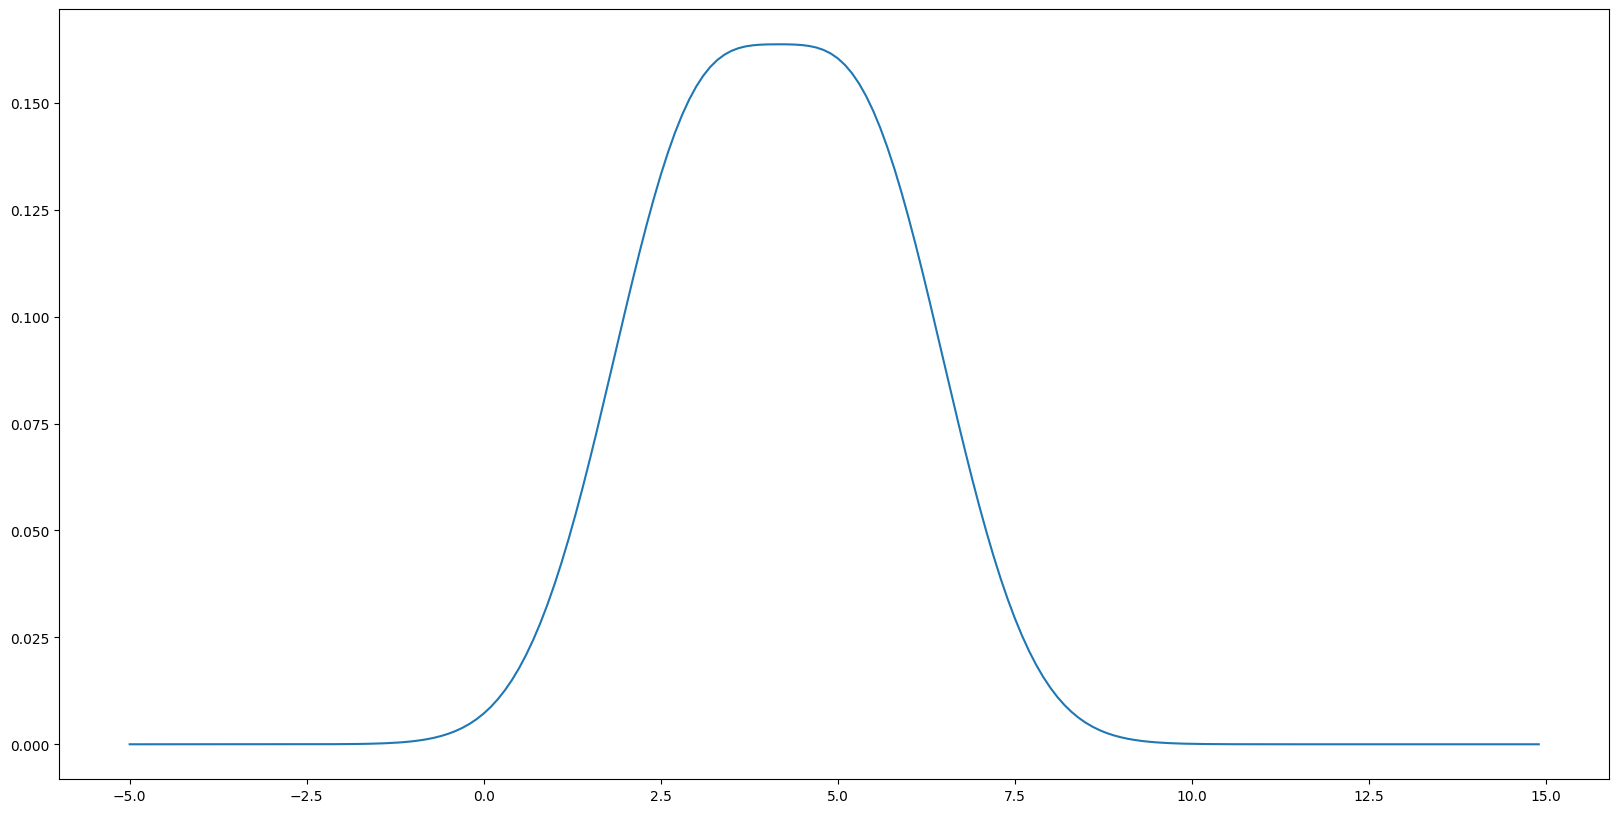

In [ ]:
kde = KDE(gaussian_kern)
result = kde.fit(X[1,:])
xs = numpy.arange(-5,15, 0.1)
ys = [result.predict(x) for x in xs]
plt.plot(xs, ys)
plt.show()

## Naive Bayes Implementation

In [ ]:
numpy.split(X, numpy.unique(y, return_index=True, return_counts=True)[1][1:])[1].shape

(30, 2)

In [ ]:
numpy.unique(y, return_index=True, return_counts=True)

(array([0., 1., 2., 3.]),
 array([  0, 200, 230, 280]),
 array([200,  30,  50, 100]))

In [ ]:
numpy.split(X, numpy.unique(y, return_index=True)[1][1:])[1].shape

(30, 2)

In [ ]:
class NaiveBayes():
  def __init__(self, kern):
    self.kern = kern

  def fit(self, X, y):
    self.n,self.d = X.shape
    grouper = numpy.unique(y, return_index=True, return_counts=True)
    Xs = numpy.split(X, grouper[1][1:])
    self.pis = grouper[2]/self.n
    self.estimator = {j:self._estimate(group) for j, group in zip(grouper[0],Xs)}
    return NaiveBayesResults(self.estimator, self.pis)

  def _estimate(self, group):
    kdes = {j:KDE(self.kern) for j in range(self.d)}
    kde_results = {j:kde.fit(group) for j, kde in kdes.items()}
    return kde_results

class NaiveBayesResults():
  def __init__(self, estimator, pis):
    self.estimator = estimator
    self.pis = pis

  def predict(self, x):
    log_probs = {}
    zeroth_estimator = self.estimator[0.0]
    for l, estimator in self.estimator.items():
      if l == 0.0: log_probs[l] = 0
      else:
        log_probs[l] = numpy.log(self.pis[round(l)]/self.pis[0])
        for j, kde in estimator.items():
          zeroth_kde = zeroth_estimator[j]
          log_probs[l] += numpy.log(kde.predict(x[j])/zeroth_kde.predict(x[j]))
    exps = [numpy.exp(p) for p in log_probs.values()]
    return numpy.array(exps)/numpy.sum(exps)



In [ ]:
nb = NaiveBayes(gaussian_kern)
res = nb.fit(X,y)

In [ ]:
res.predict(numpy.array([-1,1]))

array([0.68246963, 0.00486273, 0.00368368, 0.30898397])

In [ ]:
res.pis

array([0.52631579, 0.07894737, 0.13157895, 0.26315789])

In [ ]:
res.predict(numpy.array([2, -1]))

array([0.5107097 , 0.00295836, 0.00850222, 0.47782972])